In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

from utils.preprocessing import *
from utils.plotting import plot_single, plot_setup

%matplotlib inline

In [39]:
col = 'Byc'
myfigsize = (10, 5)

In [40]:
# df = load_data('./data/Geo_Mag_Vari_Odessa_25-31_Jan_2018.txt')
df = load_data('./data/GeoMag Odessa-Finland/01-Jun-2018 Nurmijarvi GeoMag.txt')

# df = drop_value(df, 'Bx')
df = drop_value(df, 'By')
df['Byc'] = center_data(df.By)

window_size = 17
ord = 3
orig_data = df[col]
if (True):
    df[col] = savgol_filter(df[col], window_length=window_size, polyorder=ord)
# df['Bxc'] = center_data(df.Bx)

print(df.shape)
df.head()

(86400, 3)


,Time,By,Byc
0,0.000000,14784.66,16.507351
1,0.000278,14784.63,16.465037
2,0.000556,14784.62,16.432459
3,0.000833,14784.62,16.408695
4,0.001111,14784.61,16.392821


- cubic spline with cross-validation
- LOESS Tricube / Gaussian

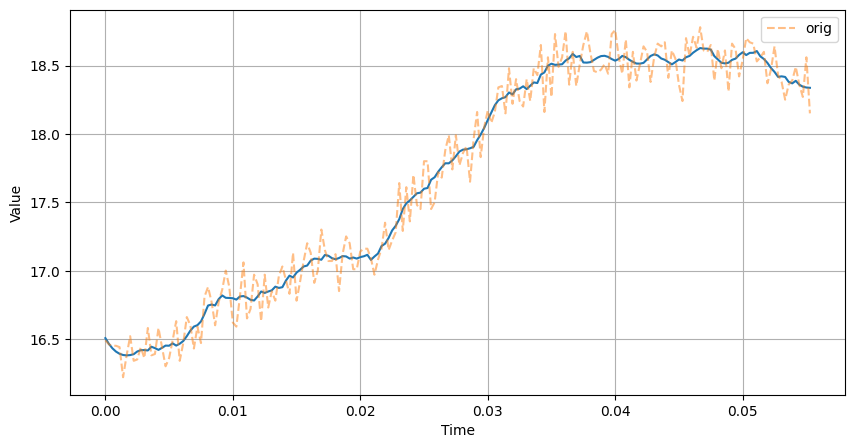

In [41]:
# interval = slice(0, -1)
interval = slice(0, 200)
plt.figure(figsize=myfigsize)
plt.plot(df.Time[interval], df[col][interval])
plt.plot(df.Time[interval], orig_data[interval], label='orig', linestyle='--', alpha=0.5)
plot_setup()

In [42]:
T = df.Time.to_numpy()[-1] - df.Time.to_numpy()[0]
dt = 1/(60*60*24)
freq_s = 1/dt  

# Filtrations

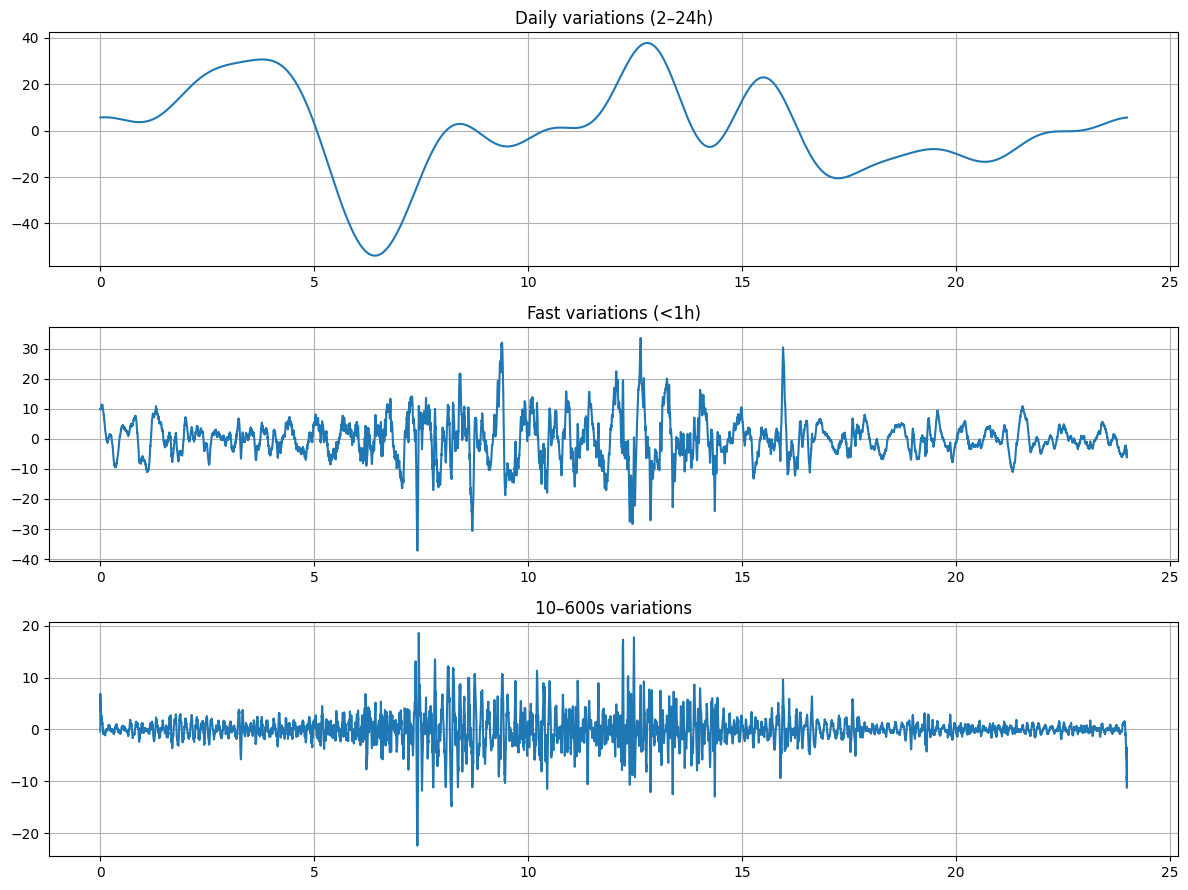

In [43]:
from scipy.fft import fft, ifft, fftfreq

fs = 1 

signal = np.array(df[col])
domain = np.array(df.Time)
N = len(signal)

fft_data = fft(signal)
freqs = fftfreq(N, d=1/fs)

daily = (np.abs(freqs) > 1/(24*60*60)) & (np.abs(freqs) < 1/(2*60*60))
fast = np.abs(freqs) > 1/3600
bandpass = (np.abs(freqs) >= 1/600) & (np.abs(freqs) <= 1/10)

fft_daily = np.zeros_like(fft_data)
fft_fast = np.zeros_like(fft_data)
fft_band = np.zeros_like(fft_data)

fft_daily[daily] = fft_data[daily]
fft_fast[fast] = fft_data[fast]
fft_band[bandpass] = fft_data[bandpass]

band_component = np.real(ifft(fft_band))
daily_component = np.real(ifft(fft_daily))
fast_component = np.real(ifft(fft_fast))

plt.figure(figsize=(12, 9))
plt.subplot(3,1,1)
plt.plot(df.Time, daily_component)
plt.title("Daily variations (2–24h)")
plt.grid()

plt.subplot(3,1,2)
plt.plot(df.Time, fast_component)
plt.title("Fast variations (<1h)")
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(df.Time, band_component)
plt.title("10–600s variations")
plt.grid()

plt.tight_layout()
plt.show()


10-600 с

automatic optimal S-G smoothing setup

- аналогично сделать через вейвлеты?

# Wigner-Ville

In [44]:
from tftb.processing import WignerVilleDistribution, PseudoWignerVilleDistribution

In [45]:
sr = 400
domain = np.array(df.Time)[::sr]
signal = np.array(df[col])[::sr]

c:\Users\Admin\diploma\utils\plotting.py:202: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


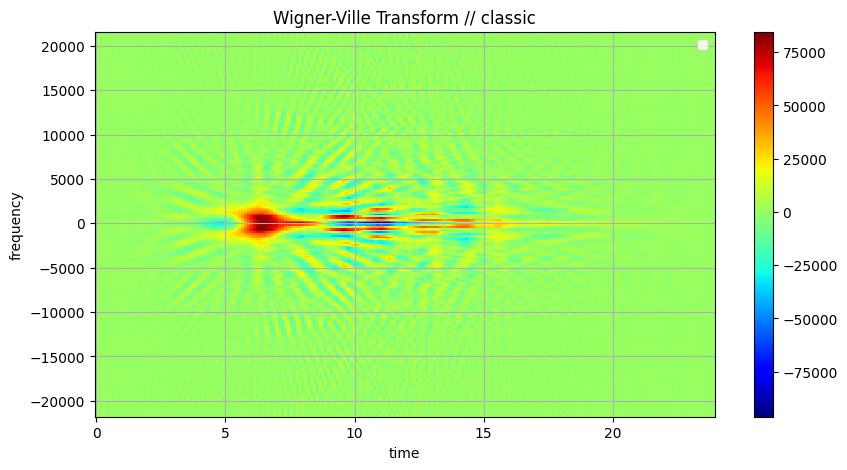

In [46]:
# classic
# wvd = WignerVilleDistribution(signal)
# tfr, t, f = wvd.run()
# wvd.plot()
# plt.show()
wvd = WignerVilleDistribution(signal, timestamps=domain)
tfr_wvd, t_wvd, f_wvd = wvd.run()

f_wvd = np.fft.fftshift(np.fft.fftfreq(tfr_wvd.shape[0], d=2 * dt))
df_wvd = f_wvd[1]-f_wvd[0]  # the frequency step in the WVT
plt.figure(figsize=myfigsize)
plt.pcolormesh(np.linspace(domain[0] - dt/2, domain[-1] + dt/2, tfr_wvd.shape[1]), np.linspace(f_wvd[0] - df_wvd/2, f_wvd[-1] + df_wvd/2, tfr_wvd.shape[0]), np.fft.fftshift(tfr_wvd, axes=0), shading='auto', cmap='jet')
plt.colorbar()
plot_setup(
        xlabel='time',
        ylabel='frequency',
        title='Wigner-Ville Transform // classic'
)

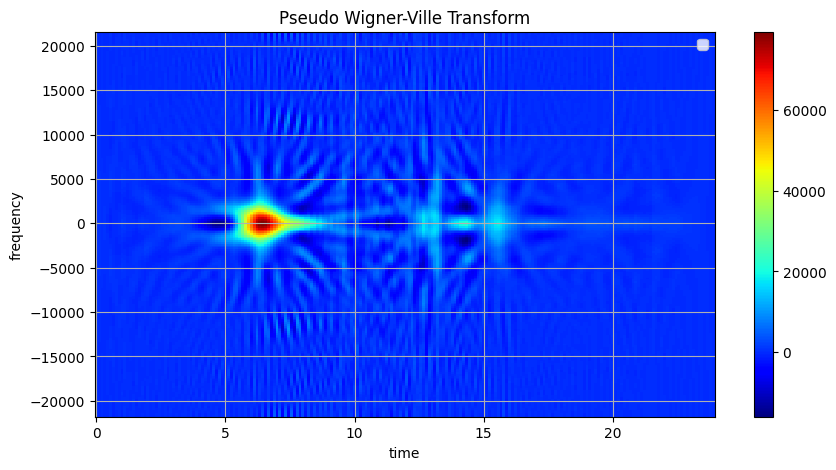

In [47]:
from tftb.processing import PseudoWignerVilleDistribution

# pwvd = PseudoWignerVilleDistribution(signal)
# tfr, t, f = pwvd.run()
# pwvd.plot()
# plt.show()

pwvd = PseudoWignerVilleDistribution(signal, timestamps=domain)
tfr_pwvd, t_pwvd, f_pwvd = pwvd.run()
f_pwvd = np.fft.fftshift(np.fft.fftfreq(tfr_pwvd.shape[0], d=2 * dt))
df_pwvd = f_pwvd[1] - f_pwvd[0]
plt.figure(figsize=myfigsize)
plt.pcolormesh(
    np.linspace(domain[0] - dt/2, domain[-1] + dt/2, tfr_pwvd.shape[1]),
    np.linspace(f_pwvd[0] - df_pwvd/2, f_pwvd[-1] + df_pwvd/2, tfr_pwvd.shape[0]),
    np.fft.fftshift(tfr_pwvd, axes=0),
    shading='auto',
    cmap='jet'
)
plt.colorbar()
plot_setup(xlabel='time', ylabel='frequency', title='Pseudo Wigner-Ville Transform')

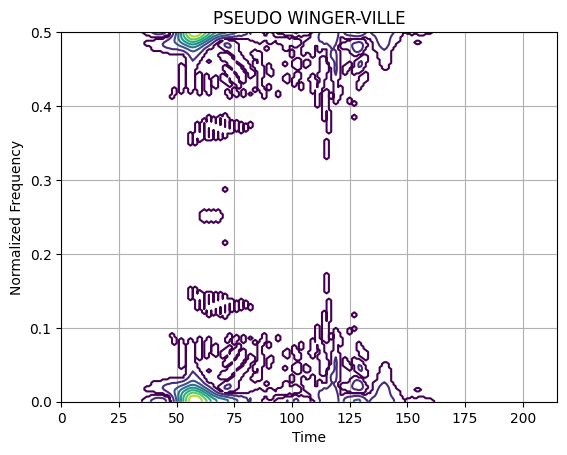

In [48]:
pwvd = PseudoWignerVilleDistribution(signal)
tfr, t, f = pwvd.run()
pwvd.plot()
# plt.colorbar()
plt.show()

# Skeleton-спектрограмма

In [49]:
dfo = load_data('./data/Geo_Mag_Vari_Odessa_25-31_Jan_2018.txt')
# df = load_data('./data/GeoMag Odessa-Finland/01-Jun-2018 Nurmijarvi GeoMag.txt')

dfo['Bxc'] = center_data(dfo.Bx)
dfo['Byc'] = center_data(dfo.By)

window_size = 17
ord = 3
if (True):
    dfo['Bxc'] = savgol_filter(dfo.Bxc, window_length=window_size, polyorder=ord)
    dfo['Byc'] = savgol_filter(dfo.Byc, window_length=window_size, polyorder=ord)


signals = np.array([dfo.Bxc, dfo.Byc])
signals.shape

(2, 604800)

In [50]:
sr = 4
domain_o = np.array(dfo.Time)[::sr]
sampled_signals = np.array(signals)[:, ::sr]
sampled_signals.shape

(2, 151200)

Sxx.shape = (65, 1349)
Sxx.shape = (65, 1349)
(65, 1349)
(2, 65, 1349)


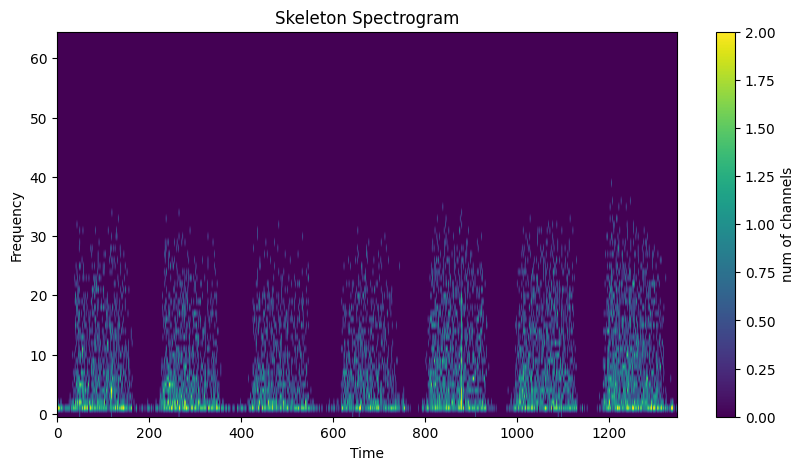

In [51]:
from scipy.signal import spectrogram
# from skimage.morphology import skeletonize

S_list = []
for x in sampled_signals:
    f, t_spec, Sxx = spectrogram(x, fs=freq_s, nperseg=128)
    S_list.append(Sxx)
    print(f'{Sxx.shape = }')

binary_specs = [(np.abs(s) > 0.01 * s.max()).astype(np.uint8) for s in S_list]
# skeletons = [skeletonize(b) for b in binary_specs]
skeleton_sum = np.sum(binary_specs, axis=0)
print(skeleton_sum.shape)
print(np.array(binary_specs).shape)

plt.figure(figsize=myfigsize)
plt.imshow(skeleton_sum, aspect='auto', origin='lower',)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("Skeleton Spectrogram")
plt.colorbar(label='num of channels')
plt.show()

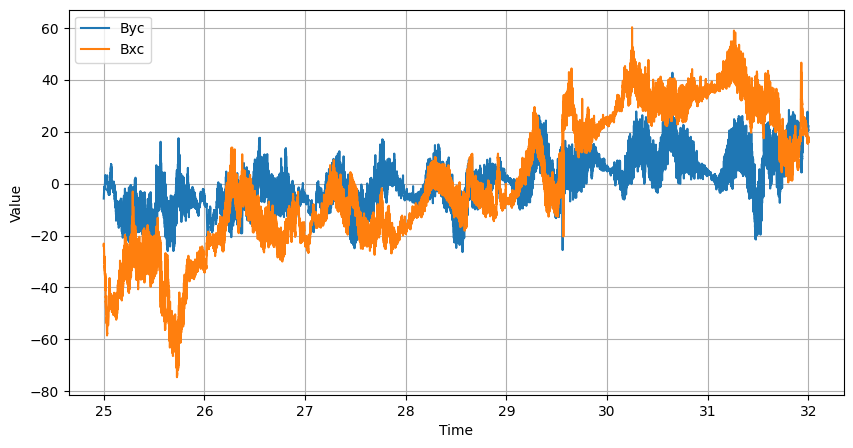

In [52]:
interval = slice(0, -1)
plt.figure(figsize=myfigsize)
plt.plot(dfo.Time[interval], dfo.Byc[interval], label='Byc')
plt.plot(dfo.Time[interval], dfo.Bxc[interval], label='Bxc')
plot_setup()

# Hilbert transform

- хотим применять к узкополосному? Т.е. сначала частотная фильтрация и оставляем только быстрые колебания?

In [56]:
signal.shape, domain.shape

((86400,), (216,))

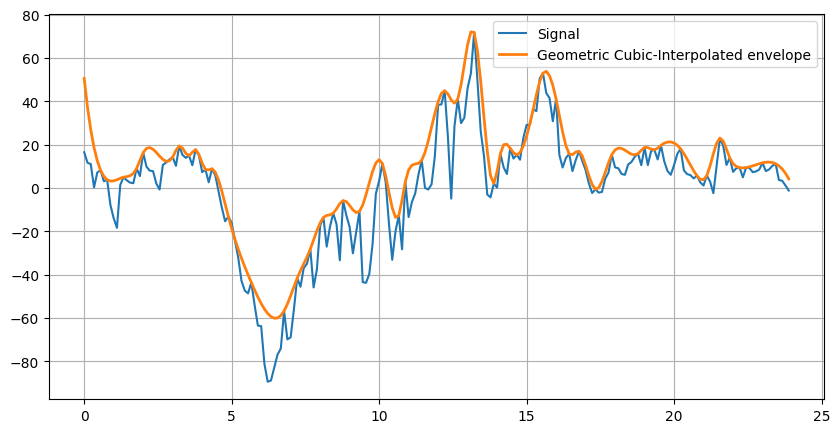

In [54]:
from scipy.signal import hilbert
from scipy.interpolate import interp1d
from utils.sup import hl_envelopes_idx

H = hilbert(signal)
envelope = np.abs(H)

_, envelopes = hl_envelopes_idx(H)

interp_env = interp1d(domain[envelopes], signal[envelopes],
                      kind='cubic', fill_value='extrapolate')

smooth_envelope = interp_env(domain)

plt.figure(figsize=myfigsize)
plt.plot(domain, signal, label='Signal')
plt.plot(domain, smooth_envelope, label='Geometric Cubic-Interpolated envelope', linewidth=2)
plt.legend()
plt.grid()
plt.show()


- добавить по Гильберту
- добавить интерполяцию

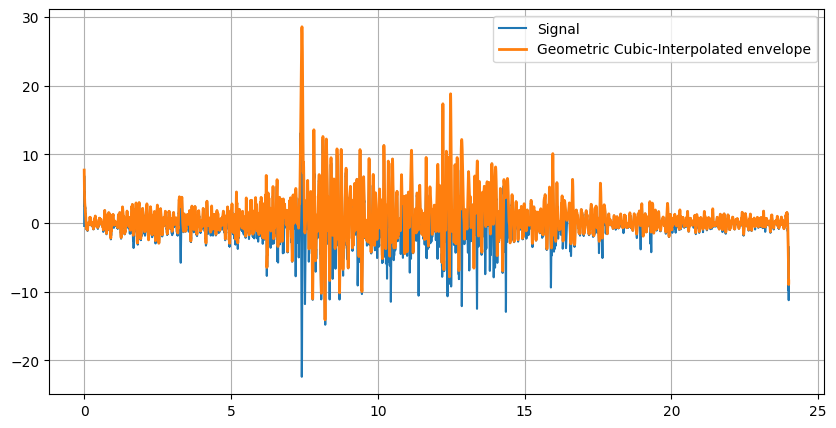

In [58]:

signal = band_component
domain = df.Time
H = hilbert(signal)
envelope = np.abs(H)

_, envelopes = hl_envelopes_idx(H)

interp_env = interp1d(df.Time[envelopes], signal[envelopes],
                      kind='cubic', fill_value='extrapolate')

smooth_envelope = interp_env(domain)

plt.figure(figsize=myfigsize)
plt.plot(domain, signal, label='Signal')
plt.plot(domain, smooth_envelope, label='Geometric Cubic-Interpolated envelope', linewidth=2)
plt.legend()
plt.grid()
plt.show()


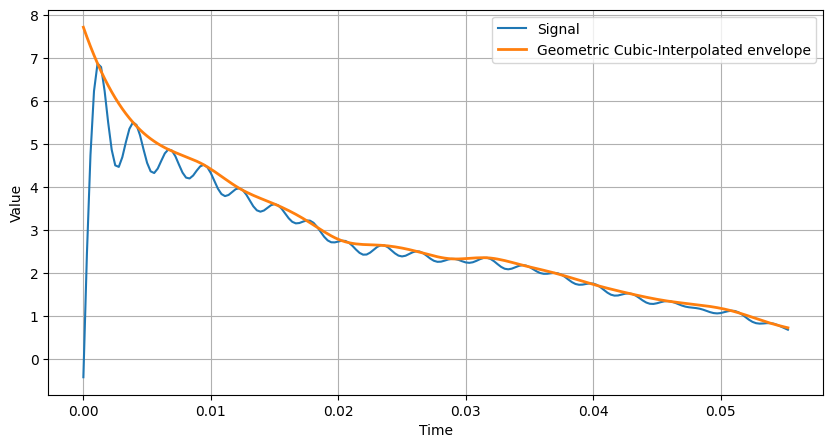

In [59]:
interval = slice(0, 200)
plt.figure(figsize=myfigsize)
plt.plot(domain[interval], signal[interval], label='Signal')
plt.plot(domain[interval], smooth_envelope[interval], label='Geometric Cubic-Interpolated envelope', linewidth=2)
plot_setup()

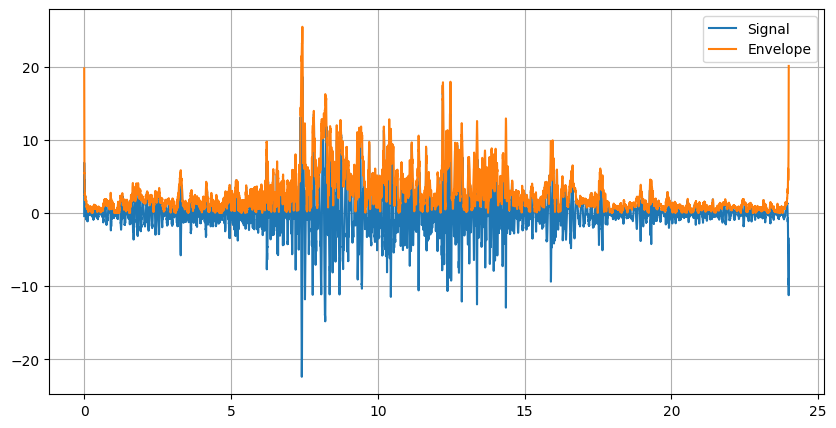

In [64]:
analytic_signal = hilbert(signal)
envelope = np.abs(analytic_signal)

plt.figure(figsize=myfigsize)
plt.plot(domain, signal, label='Signal')
plt.plot(domain, envelope, label='Envelope')
plt.legend()
plt.grid()
plt.show()


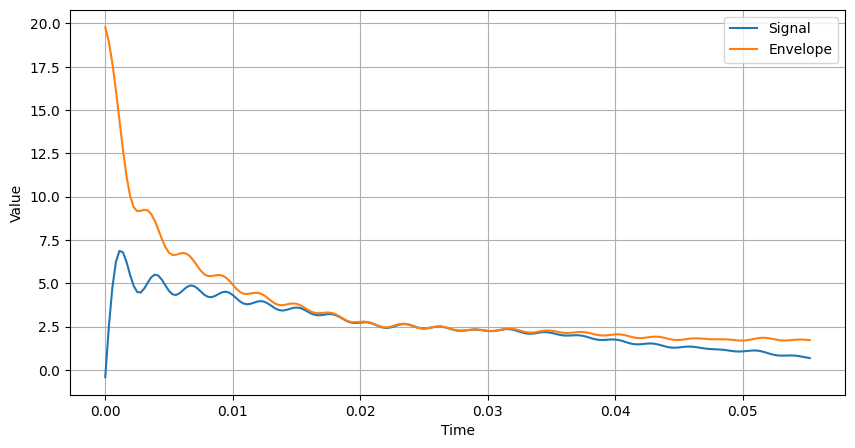

In [63]:
interval = slice(0, 200)
plt.figure(figsize=myfigsize)
plt.plot(domain[interval], signal[interval], label='Signal')
plt.plot(domain[interval], envelope[interval], label='Envelope')
plot_setup()

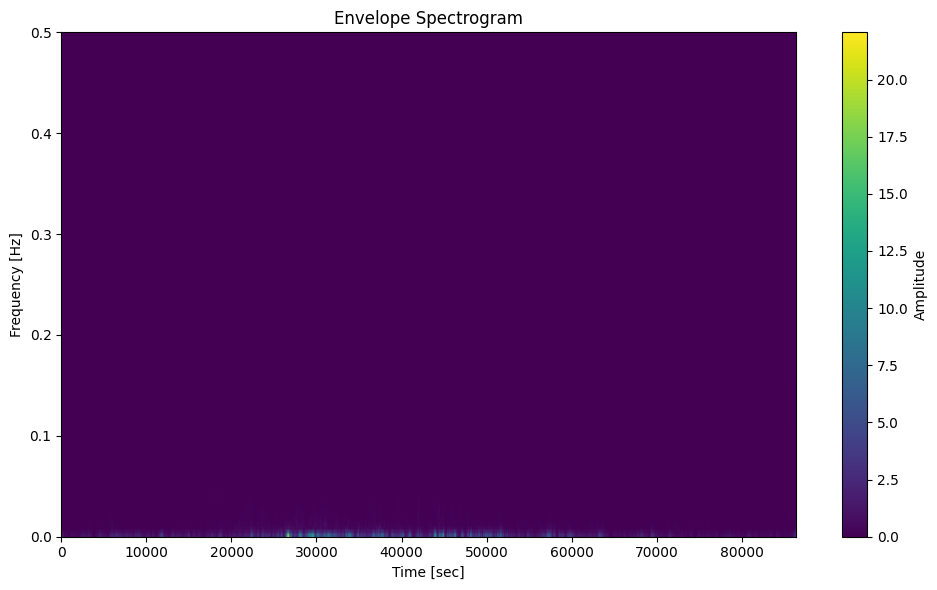

In [ ]:
from scipy.signal import stft, hilbert
import numpy as np
import matplotlib.pyplot as plt

# Compute analytic signal in time domain
analytic_signal = hilbert(signal)
envelope = np.abs(analytic_signal)

# Then do STFT on the envelope
f, t, Zxx = stft(envelope, fs=fs)

# Magnitude spectrogram
env_spec = np.abs(Zxx)

plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, env_spec, shading='gouraud')
plt.title('Envelope Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Amplitude')
plt.tight_layout()
plt.show()


In [3]:
import os

base_folder = "img/plots"  # Base path to images for LaTeX
root_dir = "plots"  # Replace with your actual folder path

for root, _, files in os.walk(root_dir):
    for file in files:
        if file.lower().endswith((".png", ".jpg", ".jpeg", ".pdf", ".eps")):
            relative_path = os.path.join(root, file).replace("\\", "/")
            latex_path = relative_path.replace(root_dir, base_folder, 1)
            print(r"\begin{figure}[H]")
            print(r"    \centering")
            print(f"    \\includegraphics[width=0.6\\linewidth]{{{latex_path}}}")
            print(r"    \caption{}")
            print(r"    \label{fig:enter-label}")
            print(r"\end{figure}")
            print()  # Blank line between figures


\begin{figure}[H]
    \centering
    \includegraphics[width=0.6\linewidth]{img/plots/01-Jun-2018/01-Jun-2018 Nurmijarvi GeoMag_fft_filters.png}
    \caption{}
    \label{fig:enter-label}
\end{figure}

\begin{figure}[H]
    \centering
    \includegraphics[width=0.6\linewidth]{img/plots/01-Jun-2018/01-Jun-2018 Nurmijarvi GeoMag_wavelet_gaus1.png}
    \caption{}
    \label{fig:enter-label}
\end{figure}

\begin{figure}[H]
    \centering
    \includegraphics[width=0.6\linewidth]{img/plots/01-Jun-2018/01-Jun-2018 Nurmijarvi GeoMag_wavelet_morl.png}
    \caption{}
    \label{fig:enter-label}
\end{figure}

\begin{figure}[H]
    \centering
    \includegraphics[width=0.6\linewidth]{img/plots/01-Jun-2018/01-Jun-2018 Nurmijarvi GeoMag_wvd.png}
    \caption{}
    \label{fig:enter-label}
\end{figure}

\begin{figure}[H]
    \centering
    \includegraphics[width=0.6\linewidth]{img/plots/01-Jun-2018/01-Jun-2018 Odessa GeoMag Astro_fft_filters.png}
    \caption{}
    \label{fig:enter-label}
\end{figure}